In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import nipy
from nipy.labs.mask import compute_mask
from skimage import exposure, img_as_float
from scipy import stats
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'DK39'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import fix_with_blob, scaled, lognorm, linnorm, fix_with_fill, equalized, remove_strip, trim_edges
from utilities.sqlcontroller import SqlController
sqlController = SqlController(animal)

Connecting dklab@192.168.1.12:3306


In [4]:
bad = [6,12,13,14,15,16,23,36,47,48,49,52,55,68,72,117,140,155,168,171,175,176, 188, 192,
       210,217, 218,241,263,267,275,295,323,327,331,339,351,354,363,369,380,388,394,395,
       417,421,422,423,424,425,427,428,429,431,432,433,435,437,445,447,451,452,453,455,456,457,458,459,
      460,461,462,463,464,465,466,467,468]
## really bad ones
reallybad = [36,155,171,217,218,295,380,388,431,432,433,437]
bads = ['{}.tif'.format(str(i).zfill(3)) for i in bad]
print(f'Need to manually fix {len(reallybad)} files or %{100*len(reallybad)/len(files)}')

Need to manually fix 12 files or %2.5806451612903225


In [5]:
def create_mask_pass1(img):
    mask1 = compute_mask(img, m=0.2, M=0.9, cc=False, opening=2, exclude_zeros=True)
    mask1 = mask1.astype(int)
    mask1[mask1==0] = 0
    mask1[mask1==1] = 255
    kernel = np.ones((5, 5), np.uint8)
    mask1 = cv2.dilate(mask1.astype(np.uint8), kernel, iterations=2)
    mask1 = mask1.astype(np.uint8)
    return mask1

#### Two pass method
1. Trims the edges of glue and junk
1. Runs through the existing fix with fill method (which has been modified again)
1. Then goes through the nipy compute_mask method (you'll need to install nipy from github

100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


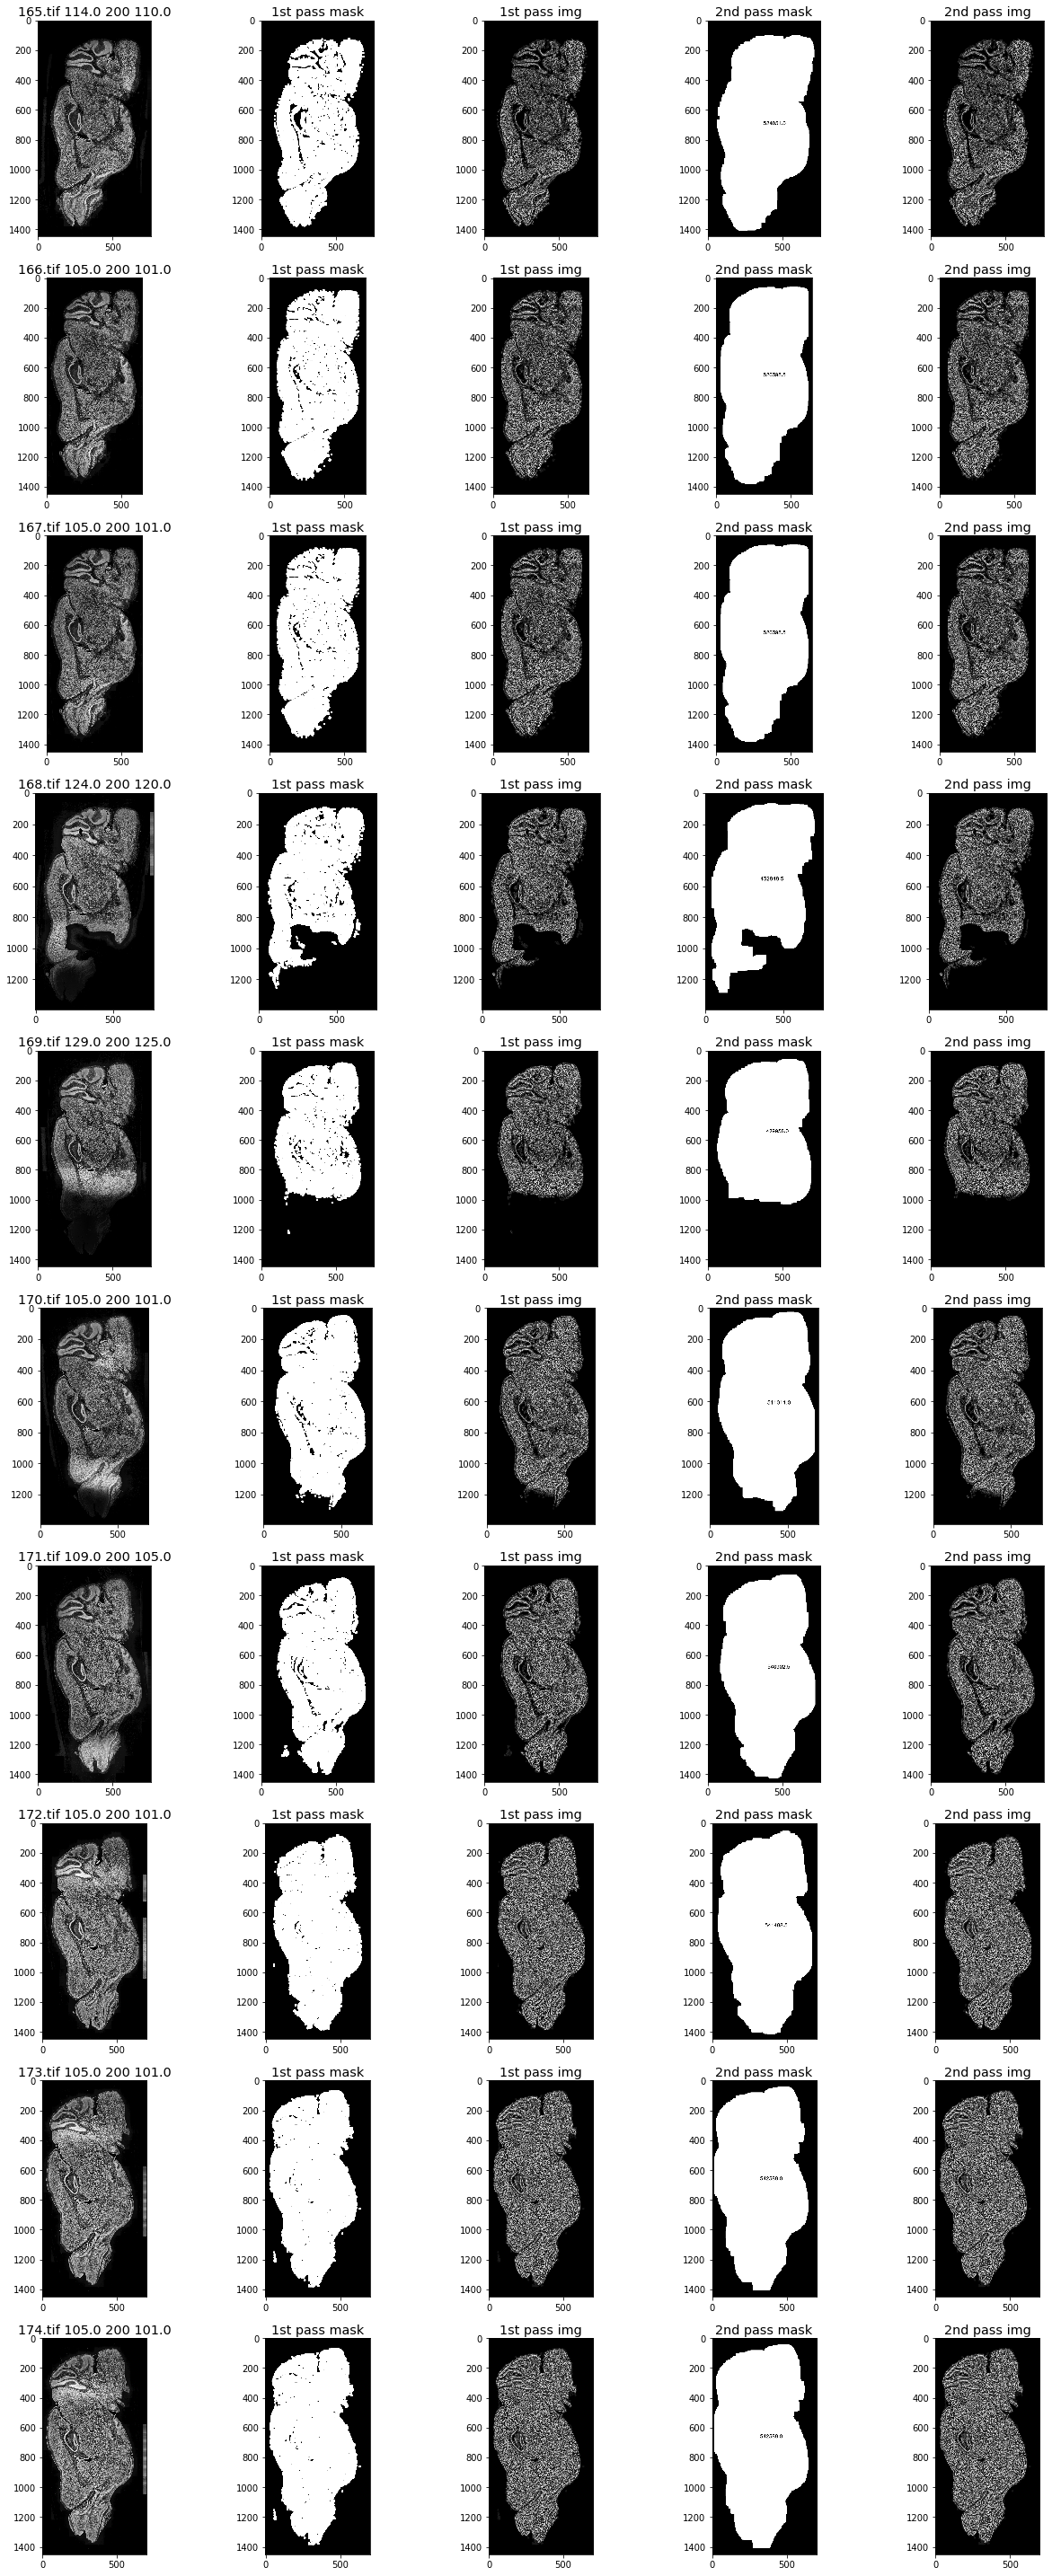

In [6]:
names = []
norms = []
masks1 = []
passes1 = []
masks2 = []
passes2 = []
start, finish = (165,175)
lowVal, highVal, threshold = (0,0,0)

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    normed = equalized(img)
    #gamma_corrected = exposure.adjust_gamma(img, 2)
    norms.append(normed)
    img = trim_edges(img)
    img = exposure.adjust_log(img, 1)
    img = exposure.adjust_gamma(img, 2)
    mask1 = create_mask_pass1(img)
    pass1 = cv2.bitwise_and(img, img, mask=mask1)
    masks1.append(mask1)    
    img2 = pass1.copy()
    passes1.append(img2)
    ## pass2
    mask2, lowVal, highVal, threshold = fix_with_fill(img2, debug=True)
    #mask2 = mask1
    pass2 = cv2.bitwise_and(img2, img2, mask=mask2)
    masks2.append(mask2)
    passes2.append(pass2)
    name = f'{file} {lowVal} {highVal} {threshold}'
    names.append(name)
    
fig, ax = plt.subplots(nrows=len(masks1), ncols=5, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask1, pass1, mask2, pass2 in zip(names, norms, masks1, passes1, masks2, passes2):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('1st pass mask')
    ax[i,1].imshow(mask1, cmap="gray")
    ax[i,2].set_title('1st pass img')
    ax[i,2].imshow(pass1, cmap="gray")
    ax[i,3].set_title('2nd pass mask')
    ax[i,3].imshow(mask2, cmap="gray")
    ax[i,4].set_title('2nd pass img')
    ax[i,4].imshow(pass2, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(masks2)]), forward=False)
plt.tight_layout()
plt.show()